In [4]:
import hashlib 
import random
import math
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from collections import Counter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
inf = math.inf
def hex_id(id):
    return hashlib.md5(str(id).encode()).hexdigest()
def random_num(a,b):
    return a + random.random()*(b-a)
def euclidean_distance(a,b):
    return np.linalg.norm(np.array(a)-np.array(b))
def node_abs_id_distance(a,b):
    return abs(int(a,16) - int(b,16))
def node_id_distance(a,b):
    return int(a,16) - int(b,16)
def comman_prefix_length(a,b):
    ct = 0
    for i in range(0,len(a)):
        if a[i] == b[i]:
            ct += 1
        else:
            return ct
    return ct

def compare(a,b,mode="eq"):
    if mode == "eq":
        return int(a,16) == int(b,16)
    if mode == "g":
        return int(a,16) > int(b,16)
    if mode == "l":
        return int(a,16) < int(b,16)
    if mode == "ge":
        return int(a,16) >= int(b,16)
    if mode == "le":
        return int(a,16) <= int(b,16)
def min_node_id(leafSet):
        return min(leafSet,key = lambda val: int(val,16))
    
def max_node_id(leafSet):
        return max(leafSet,key = lambda val: int(val,16))
    
def get_prob_distribution(lst):
    
    a = Counter(lst)
    ct = sum(a.values())

    vals = list(a.keys())
    probs = [item*1.0/ct for item in a.values()]
    idx   = np.argsort(vals)
    vals = np.array(vals)[idx]
    probs = np.array(probs)[idx]
    return vals,probs

In [5]:
class Key():
    def __init__(self,key):
        self.name = key
        self.id = hex_id(self.name)
        

class Node():
    def __init__(self,node_name,b=4):
        self.name = node_name
        self.id = hex_id(self.name)
        self.data = {}
        self.b = b
        self.L = self.M = int(math.pow(2,b))
        self.location = (random_num(0,90),random_num(0,180))## latitude and longitude
        self.routingTable = [[ None for item in range(0,int(math.pow(2,self.b)))] for i in range(0,int(128/self.b))] ## b = 4 configuration
        self.leafUSet = [] ### Upper leaf set
        self.leafLSet = [] ### Lower leaf set
        self.nbrSet = []
        self.isOnRoute = False

    def findNearestLeafNode(self,key): ### Accepts id
        nearest_node = None
        nearest_node_dist = inf
        for nbr in self.leafUSet + self.leafLSet:
            distance = node_abs_id_distance(nbr,key)
            if nearest_node_dist > distance:
                nearest_node_dist = distance
                nearest_node = nbr
        return nearest_node
    def check_if_key_lies_in_leaf_range(self,key):
        if len(self.leafUSet) == 0 and len(self.leafLSet) == 0:
            return False
        
        if len(self.leafUSet) == 0:
            return compare(key,min_node_id(self.leafLSet),"ge") and compare(key,self.id,'le')
        if len(self.leafLSet) == 0:
            return compare(key,max_node_id(self.leafUSet),'le') and compare(key,self.id,'ge')
        return compare(key,min_node_id(self.leafLSet),'ge') and compare(key,max_node_id(self.leafUSet),'le')
    
    def find_closest_node_in_routing_table(self,key,node_id_to_object):   ## This is tough
        shl = comman_prefix_length(self.id,key.id)
        node = self.routingTable[shl][int(key.id[shl],16)]
        if node is not None and node in node_id_to_object:
            return node
        else:
            for node in self.leafUSet + self.leafLSet:
                if node in node_id_to_object:
                    shl_node = comman_prefix_length(node,key.id)
                    if node_abs_id_distance(node,key.id) < node_abs_id_distance(node,self.id) and shl_node >= shl:
                        return node
            for row in self.routingTable:
                for node in row:
                    if node is not None and node in node_id_to_object:
                        shl_node = comman_prefix_length(node,key.id)
                        if node_abs_id_distance(node,key.id) < node_abs_id_distance(node,self.id) and shl_node >= shl:
                            return node
            
            return None
        
    def add_key(self,key,value,node_id_to_object,mode,ct=0):  ## mode can be of deletion
        #if self.isOnRoute:
        #print("Come to, ", self.name," ", self.id)
        #if 
        ct += 1
        if ct > 100:
            return (None,None,None)
        if mode == "find":
            if key.name in self.data:
                return (self.data[key.name],0,[self.id])
        
        if_lies_in_node_range = self.check_if_key_lies_in_leaf_range(key.id)
        leaf_node_id = self.findNearestLeafNode(key.id)
            
        if if_lies_in_node_range and leaf_node_id is not None and leaf_node_id in node_id_to_object:
            leaf_node = node_id_to_object[leaf_node_id]
            if node_abs_id_distance(leaf_node.id,key.id) <= node_abs_id_distance(self.id,key.id):
                val,hops,route = leaf_node.add_key(key,value,node_id_to_object,mode)
                if val is None and hops is None and route is None:
                    return (None,None,None)
                return (val,hops+1,[self.id]+route)
            else:
                if mode == "find":
                    if key.name in self.data:
                        return (self.data[key.name],0,[self.id])
                    return (None,0,[self.id])
                else:
                    if mode == "find_closest_node":
                        return (self.id,0,[self.id])
                    
                    self.data[key.name] = value
                    return (value,0,[self.id])
        routing_node_id = self.find_closest_node_in_routing_table(key,node_id_to_object)
        if routing_node_id is not None and routing_node_id in node_id_to_object:
            routing_table_node = node_id_to_object[routing_node_id]
            #print(routing_table_node.name,routing_table_node.id)
            val,hops,route = routing_table_node.add_key(key,value,node_id_to_object,mode,ct)
            if val is None and hops is None and route is None:
                return (None,None,None)
            return (val,hops+1,[self.id]+route)
        if mode== "addition":
            self.data[key.name] = value
            return (value,0,[self.id])
        if mode == "find_closest_node":
            return (self.id,0,[self.id])
        return (None,0,[self.id])
    
    
    def updateLeafNodes(self,node):
        leaf_nodes = node.leafUSet + [node.id] + node.leafLSet
        distances_high = []
        distances_low = []
        for nbr in leaf_nodes:
            if nbr != self.id:
                distance = node_id_distance(nbr,self.id)
                if distance > 0:
                    distances_high.append((nbr,distance))
                else:
                    distances_low.append((nbr,abs(distance)))

        
        distances_high.sort(key=lambda val: val[1],reverse=False)
        distances_low.sort(key=lambda val: val[1], reverse= False)
        self.leafUSet = [item[0] for item in distances_high[:int(self.L/2)]]
        self.leafLSet = [item[0] for item in distances_low[:int(self.L/2)]]
        return         
        
    def updateMembershipNodes(self,node,id_to_node):
        local_nodes = node.nbrSet + [node.id]
        distances = []
        for nbr in local_nodes:
            if nbr != self.id:
                distance = euclidean_distance(id_to_node[nbr].location,self.location)
                distances.append((nbr,distance))
        distances.sort(key=lambda val: val[1],reverse=False)
        self.nbrSet =[item[0] for item in distances[0:self.M]]
        return
    
    def updateRoutingTable(self,route):
        ct= 0
        for node in route:
            shl = comman_prefix_length(self.id,node.id)
            if ct == 0:
                for i in range(0,shl+1):
                    self.routingTable[i] = node.routingTable[i]
            else:
                if self.routingTable[shl][0] is None:
                    self.routingTable[shl] = node.routingTable[i]
        return
    
    def stabilize(self,node_id_to_object):
        #print("self id ,",self.id)
        newleafSet = []
        lost = False
        lost_index_upper = -1
        lost_index_lower = -1
        ct = 0
        removed_node_id = None
        for nodeid in self.leafUSet:
            if nodeid not in node_id_to_object:
                lost = True
                lost_index_upper = ct
                removed_node_id = nodeid
                break
            ct += 1
        ct = 0
        if lost_index_upper == -1:
            for nodeid in self.leafLSet:
                if nodeid not in node_id_to_object:
                    lost = True
                    lost_index_lower = ct
                    removed_node_id = nodeid
                    break
                ct += 1
        len_lset = len(self.leafLSet)
        len_uset = len(self.leafUSet)
        if lost and (len_lset > 0 or len_uset >0):
            ask_leaf_node_from = None     

            if lost_index_upper != -1:
                if len_uset > 1:
                    if lost_index_upper == len_uset - 1:
                        ask_leaf_node_from = self.leafUSet[len_uset-2]
                    else:
                        ask_leaf_node_from = self.leafUSet[len_uset-1]
                else:
                    self.leafUSet = []
                
            else:
                if lost_index_lower != -1:
                    if len_lset > 1:
                        #print("index, ", lost_index_lower,len_lset, )
                        if lost_index_lower == len_lset - 1:
                            ask_leaf_node_from = self.leafLSet[len_lset-2]
                        else:
                            ask_leaf_node_from = self.leafLSet[len_lset-1]
                    else:
                        self.leafLSet = []
            if ask_leaf_node_from is not None:
                ask_leaf_node_from = node_id_to_object[ask_leaf_node_from]
                newLeafSet = list(set(self.leafLSet + self.leafUSet + ask_leaf_node_from.leafLSet + ask_leaf_node_from.leafUSet))
                newLeafSet.remove(removed_node_id)
                distances_high = []
                distances_low = []
                for nbr in newLeafSet:
                    if nbr != self.id:
                        distance = node_id_distance(nbr,self.id)
                        #print(distance)
                        if distance > 0:
                            distances_high.append((nbr,distance))
                        else:
                            distances_low.append((nbr,abs(distance)))


                distances_high.sort(key=lambda val: val[1],reverse=False)
                distances_low.sort(key=lambda val: val[1], reverse= False)
                self.leafUSet = [item[0] for item in distances_high[:int(self.L/2)]]
                self.leafLSet = [item[0] for item in distances_low[:int(self.L/2)]]
                #print(len(self.leafUSet),len(self.leafLSet))
            
        else:
            if lost:
                self.leafUSet = []
                self.leafLSet = []
                
                
                
        #if not lost:
            #### repair routing table
        row_index = 0
        import copy
        dup = copy.deepcopy(self.routingTable.copy())
        dup1 = copy.deepcopy(self.routingTable.copy())
        for row in dup:
            for node in row: 
                col_index = 0
                if node is not None and node not in node_id_to_object:
                    found = False
                    #print("Found, ", self.id, row_index,col_index,  node)
                    # node is dropped###
                    self.routingTable[row_index][col_index] = None
                    
                    for new_row in dup1:
                        for new_node in new_row:
                            if not found:
                                if new_node is not None and new_node in node_id_to_object and new_node != node and  node_id_to_object[new_node].routingTable[row_index][col_index] is not None and node_id_to_object[new_node].routingTable[row_index][col_index] in node_id_to_object:
                                    #print(row_index,col_index)
                                    self.routingTable[row_index][col_index] = node_id_to_object[new_node].routingTable[row_index][col_index]
                                    found = True
                                    #print(self.routingTable[row_index][col_index])
                col_index +=1
            row_index += 1
                
        return   
        
    def updateState(self,new_node,node_id_to_object):
        self.updateLeafNodes(new_node)
        self.updateMembershipNodes(new_node,node_id_to_object)
        shl = comman_prefix_length(self.id,new_node.id)
        location = int(new_node.id[shl],16)

        existing_node_id = self.routingTable[shl][location]
        if existing_node_id is None:
            self.routingTable[shl][location] = new_node.id
        else:
            existing_node = node_id_to_object[existing_node_id]
            if euclidean_distance(new_node.location,self.location) < euclidean_distance(existing_node.location,self.location):
                self.routingTable[shl][location] = new_node.id
            
        return 
    def print_node_properties(self):
        print("Name," , self.name)
        print("Id,", self.id)
        print("location, ", self.location)
        print("leaf Upper set",self.leafUSet)
        print("leaf Lower set", self.leafLSet)
        print("nbr set", self.nbrSet)
        print("Routing Table")
        df = pd.DataFrame.from_records(self.routingTable)
        display(df)



class Pastry():
    def __init__(self,num_of_nodes):
        self.N = num_of_nodes
        self.nodes = []
        self.node_id_to_object = {}
        for i in range(0, num_of_nodes):  ### Creating nodes
            node = Node(i)
            self.nodes.append(node)
            self.node_id_to_object[node.id] = node
        for i in range(0,num_of_nodes):
            self.updateLeafNodes(self.nodes[i])
            self.updateLocalNode(self.nodes[i])
            self.updateRoutingTable(self.nodes[i])
    
    
        self.add_queries = 0
        self.delete_queries = 0
        self.search_queries = 0
        self.data_add_queries = 0
    def findNearestNode(self,node):
        nearest_node = None
        nearest_node_dist = inf
        for nbr in self.nodes:
            
            distance = node_abs_id_distance(nbr.id,node.id)
            if nearest_node_dist > distance:
                nearest_node_dist = distance
                nearest_node = nbr
        return nearest_node
    
    def updateRoutingTable(self,node):
        routingTable = [[ [] for item in range(0,int(math.pow(2,node.b)))] for i in range(0,int(128/node.b))] ## b = 4 configuration
        for nbr in self.nodes:
            if nbr.id != node.id:
                shl = comman_prefix_length(node.id,nbr.id)
                routingTable[shl][int(nbr.id[shl],16)].append(nbr.id)
        for i in range(0,len(routingTable)):
            for j in range(0,len(routingTable[i])):
                if len(routingTable[i][j]) == 0:
                    node.routingTable[i][j] = None
                else:
                    distances = []
                    for nbr in routingTable[i][j]:
                        distances.append((nbr,euclidean_distance(self.node_id_to_object[nbr].location,node.location)))
                    distances.sort(key=lambda val:val[1],reverse= False)
                    node.routingTable[i][j] = distances[0][0]  ## stored the closest nbr node
        return
        
    def updateLocalNode(self,node):
        distances = []
        for nbr in self.nodes:
            if nbr.id != node.id:
                distance = euclidean_distance(nbr.location,node.location)
                distances.append((nbr.id,distance))
        distances.sort(key=lambda val: val[1],reverse=False)
        node.nbrSet =[item[0] for item in distances[0:node.M]]
        return
    
    
    
    def updateLeafNodes(self,node):
        distances_high = []
        distances_low = []
        for nbr in self.nodes:
            if nbr.id != node.id:
                distance = node_id_distance(nbr.id,node.id)
                if distance > 0:
                    distances_high.append((nbr.id,distance))
                else:
                    distances_low.append((nbr.id,abs(distance)))

        
        distances_high.sort(key=lambda val: val[1],reverse=False)
        distances_low.sort(key=lambda val: val[1], reverse= False)
        node.leafUSet = [item[0] for item in distances_high[:int(node.L/2)]]
        node.leafLSet = [item[0] for item in distances_low[:int(node.L/2)]]
        return 
    
    def add_key(self,key,value,mode="addition",ct=0):
        if mode == "addition":
            self.add_queries += 1
        if mode == "find":
            self.search_queries += 1
        
        node_index= random.choice(range(0,self.N))
        return self.nodes[node_index].add_key(key,value,self.node_id_to_object,mode,ct)
    
    def add_node(self):
        node = Node(self.N+1)
        self.node_id_to_object[node.id] = node
        self.nodes.append(node)
        random_node= self.nodes[random.choice(range(0,self.N))]
        self.N += 1
        nearest_node,hops,route = random_node.add_key(node,'',self.node_id_to_object,"find_closest_node")
        node.updateLeafNodes(self.node_id_to_object[nearest_node])
        node.updateMembershipNodes(self.node_id_to_object[nearest_node],self.node_id_to_object)
        node.updateRoutingTable([self.node_id_to_object[id] for id in route])
        
        
        for nbr in node.leafLSet + node.leafUSet + node.nbrSet + [item  for row in node.routingTable for item in row ]:
            if nbr is not None:
                nbr_node = self.node_id_to_object[nbr]
                nbr_node.updateState(node,self.node_id_to_object)
            
            
        return "success"
    def delete_node(self):
        self.delete_queries += 1
        index= random.choice(range(0,self.N))
        del self.node_id_to_object[self.nodes[index].id]
        del self.nodes[index]
        self.N = self.N-1
        for node in self.nodes:
            node.stabilize(self.node_id_to_object)
        return
    def print_network_information(self):
        print("Number of active nodes , " , len(self.nodes))
        print("Number of data add queries, ", self.add_queries)
        print("Number of delete node queries" , self.delete_queries)
        print("Number of search queries, ", self.search_queries)
        data_len= 0
        for node in self.nodes:
            data_len += len(node.data)
        print("Current data stored ", data_len)


Creating network for  100
adding data points
Searching,
Number of active nodes ,  100
Number of data add queries,  10000
Number of delete node queries 0
Number of search queries,  1000000
Current data stored  10000
deleting 50% nodes
searching for queries
Creating network for  500
adding data points
Searching,
Number of active nodes ,  500
Number of data add queries,  10000
Number of delete node queries 0
Number of search queries,  1000000
Current data stored  10000
deleting 50% nodes
searching for queries
Creating network for  1000
adding data points
Searching,
Number of active nodes ,  1000
Number of data add queries,  10000
Number of delete node queries 0
Number of search queries,  1000000
Current data stored  10000
deleting 50% nodes
searching for queries


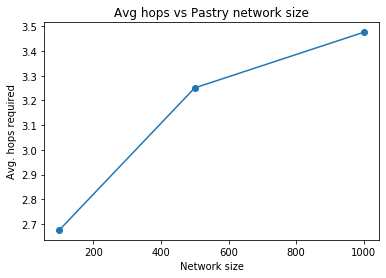

In [55]:
num_of_nodes = [100,500,1000]
hops_per_nodes = []
for nodes in num_of_nodes:
    print("Creating network for ", nodes)
    pastry = Pastry(nodes)
    print("adding data points")
    keys = []
    for i in range(0,10000):
        key = Key(i)
        keys.append(key)
        pastry.add_key(key,"val_"+str(key.name),"addition")
    hops_needed = []
    print("Searching,")
    for i in range(0,1000000):
        key = random.choice(keys)
        hops = pastry.add_key(key,"","find",0)[-1]
        if hops is not None:
            hops_needed.append(len(hops))
    hops_per_nodes.append(np.mean(hops_needed))
    vals,probs = get_prob_distribution(hops_needed)
    pastry.print_network_information()
    plt.clf()
    plt.bar(vals, probs,width=0.3)
    #plt.hist(hops_needed) # density
    plt.ylabel('Probability')
    plt.xlabel('Number of hops')
    plt.title("Distribution of hops required for 1 million queries in "+str(nodes) +" size network")
    plt.savefig(str(nodes)+"_search_queries.svg")
    print("deleting 50% nodes")
    for i in range(0,int(nodes*.5)):
    #print("deleting , i ", i)
        pastry.delete_node()
    print("searching for queries")
    for i in range(0,1000000):
        key = random.choice(keys)
        hops = pastry.add_key(key,"","find",0)[-1]
        if hops is not None:
            hops_needed.append(len(hops)+1)
    vals,probs = get_prob_distribution(hops_needed)
    plt.clf()
    plt.bar(vals, probs,width=0.3)
    #plt.hist(hops_needed) # density
    plt.ylabel('Probability')
    plt.xlabel('Number of hops')
    plt.title("Distribution of hops required for 1 million queries after deletion")
    plt.savefig(str(nodes)+"_delete_search_queries.svg")
    
plt.clf()
plt.plot(num_of_nodes, hops_per_nodes,'o-')
#plt.hist(hops_needed) # density
plt.ylabel('Avg. hops required')
plt.xlabel('Network size')
plt.title("Avg hops vs Pastry network size")
plt.savefig("pastry_avg_hops_needed.svg")


In [6]:

pastry = Pastry(500)

In [7]:
pastry.nodes[0].print_node_properties()

Name, 0
Id, cfcd208495d565ef66e7dff9f98764da
location,  (0.11212465212515621, 126.1909024701648)
leaf Upper set ['cfecdb276f634854f3ef915e2e980c31', 'cfee398643cbc3dc5eefc89334cacdc1', 'd07e70efcfab08731a97e7b91be644de', 'd09bf41544a3365a46c9077ebb5e35c3', 'd18f655c3fce66ca401d5f38b48c89af', 'd1c38a09acc34845c6be3a127a5aacaf', 'd1f255a373a3cef72e03aa9d980c7eca', 'd1f491a404d6854880943e5c3cd9ca25']
leaf Lower set ['cfa0860e83a4c3a763a7e62d825349f7', 'cf004fdc76fa1a4f25f62e0eb5261ca3', 'cedebb6e872f539bef8c3f919874e9d7', 'cd00692c3bfe59267d5ecfac5310286c', 'cb70ab375662576bd1ac5aaf16b3fca4', 'caf1a3dfb505ffed0d024130f58c5cfa', 'ca46c1b9512a7a8315fa3c5a946e8265', 'c9f0f895fb98ab9159f51fd0297e236d']
nbr set ['c9f0f895fb98ab9159f51fd0297e236d', '072b030ba126b2f4b2374f342be9ed44', '8d7d8ee069cb0cbbf816bbb65d56947e', 'f7e6c85504ce6e82442c770f7c8606f0', '310dcbbf4cce62f762a2aaa148d556bd', '4f4adcbf8c6f66dcfc8a3282ac2bf10a', '63dc7ed1010d3c3b8269faf0ba7491d4', '19f3cd308f1455b3fa09a282e0d496f4'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,072b030ba126b2f4b2374f342be9ed44,19f3cd308f1455b3fa09a282e0d496f4,20f07591c6fcb220ffe637cda29bb3f6,310dcbbf4cce62f762a2aaa148d556bd,4f4adcbf8c6f66dcfc8a3282ac2bf10a,58a2fc6ed39fd083f55d4182bf88826d,63dc7ed1010d3c3b8269faf0ba7491d4,7e7757b1e12abcb736ab9a754ffb617a,8d7d8ee069cb0cbbf816bbb65d56947e,93db85ed909c13838ff95ccfa94cebd9,a0a080f42e6f13b3a2df133f073095dd,bd686fd640be98efaae0091fa301e613,None,d96409bf894217686ba124d7356686c9,ed3d2c21991e3bef5e069713af9fa6ca,f7e6c85504ce6e82442c770f7c8606f0
1,c058f544c737782deacefa532d9add4c,c16a5320fa475530d9583c34fd356ef5,c203d8a151612acf12457e4d67635a95,c3e878e27f52e2a57ace4d9a76fd9acf,c4ca4238a0b923820dcc509a6f75849b,c5ff2543b53f4cc0ad3819a36752467b,None,c74d97b01eae257e44aa9d5bade97baf,c86a7ee3d8ef0b551ed58e354a836f2b,c9f0f895fb98ab9159f51fd0297e236d,caf1a3dfb505ffed0d024130f58c5cfa,cb70ab375662576bd1ac5aaf16b3fca4,None,cd00692c3bfe59267d5ecfac5310286c,cedebb6e872f539bef8c3f919874e9d7,None
2,cf004fdc76fa1a4f25f62e0eb5261ca3,None,None,None,None,None,None,None,None,None,cfa0860e83a4c3a763a7e62d825349f7,None,None,None,cfecdb276f634854f3ef915e2e980c31,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [8]:
# def print_node_properties(node):
#     print("Name," , node.name)
#     print("Id,", node.id)
#     print("Geographical location, ", node.location)
#     print()
#     print("Upper Leaf set - ",node.leafUSet)
#     print()
#     print("Lower Leaf set - ", node.leafLSet)
#     print()
#     print("Nbr. set", node.nbrSet)
#     print()
#     print("Routing Table")
#     df = pd.DataFrame.from_records(node.routingTable)
#     display(df)
# print_node_properties(pastry.nodes[5])